In [27]:
from statistics import mean
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from hurst import compute_Hc
import math

In [89]:
class Pair:
    P_VALUE_THRESHOLD = 0.05
    HURST_THRESHOLD = 0.5
    MIN_MEAN_CROSSES = 12
    TRADING_BOUND = 1
    EXIT_PROFIT = 0
    STOP_LOSS = 2
    RETURN_ON_BOTH_LEGS = False
    WAITING_PERIOD = 30
    TRADING_PERIOD = 253
    #percentage of transaction costs
    TC = 0
    
    def __init__(self, 
                 stockX, stockY, 
                 trading_period = TRADING_PERIOD, 
                 waiting_period = WAITING_PERIOD, 
                 trading_bound = TRADING_BOUND, 
                 exit_profit = EXIT_PROFIT, 
                 stop_loss = STOP_LOSS,
                 return_on_both_legs = RETURN_ON_BOTH_LEGS,
                 tc = TC):
        self.name = f"{stockX.name}, {stockY.name}"
        self.stockX_trading = stockX[-trading_period:]
        self.stockY_trading = stockY[-trading_period:]
        
        self.trading_period = trading_period
        self.waiting_period = waiting_period
        self.exit_profit = exit_profit
        self.trading_bound = trading_bound
        self.stop_loss = stop_loss
        self.return_on_both_legs = return_on_both_legs
        self.tc = tc
        
        self.error = False
        try:
            beta = OLS(stockY[-trading_period:], stockX[-trading_period:]).fit().params[0]
            self.spread = stockY[-trading_period] - beta * stockX[-trading_period:]
            self.normalized_spread_trading = (self.spread - self.spread.mean()) / self.spread.std()
            self.p_value = coint(stockX, stockY)[1] 
            self.hurst = compute_Hc(self.spread)[0]
            self.generate_trading_signals()
        except Exception as e:
            print(e)
            print(f"Error encountered with pair [{self.stockX_trading.name}, {self.stockY_trading.name}]")
            self.error = True
            
    def eligible(self, p_value_threshold = P_VALUE_THRESHOLD, hurst_threshold = HURST_THRESHOLD, min_mean_crosses = MIN_MEAN_CROSSES):
        if self.error:
            return False
        elif self.p_value <= p_value_threshold and self.hurst <= hurst_threshold and self.mean_crosses >= min_mean_crosses:
            return True
        return False
    
    def __level_crosses(self, series, level = 2):
        change = []
        for i, el in enumerate(series):
            if i != 0 and el > level and series[i-1] < level:
                change.append(1)
            elif i != 0 and el < level and series[i-1] > level:
                change.append(-1)
            else:
                change.append(0)
        return change
    
    def __average_holding_period(self):
        holding_periods = []
        for closed_date in self.closed_positions:
            open_date = list(filter(lambda x: x < closed_date, self.open_positions))[-1]
            holding_periods.append(closed_date - open_date)
        return mean(holding_periods)
    
    def __calculate_returns(self, pos_x, pos_y, i):
        if pos_x[2] == 'l':
            #cost of the long = opening price * number of stocks bought
            cost_long = pos_x[0] * pos_x[1] 
            profit = (self.stockX_trading[i] - self.pos_x[0]) * pos_x[1] + (self.pos_y[0] - self.stockY_trading[i]) * pos_y[1]
        else:
            #long on Y
            cost_long = pos_y[0] * pos_y[1]
            profit = (self.pos_x[0] - self.stockX_trading[i]) * pos_x[1] + (self.stockY_trading[i] - self.pos_y[0]) * pos_y[1]
        if self.return_on_both_legs:
            return_before_tc = profit / (pos_x[0] * pos_x[1] + pos_y[0] * pos_y[1]) * 100
            return return_before_tc - (self.tc / 100) * return_before_tc
        else:
            #calculate the return only on the cost of long position
            return_before_tc = profit / cost_long * 100
            return return_before_tc - (self.tc / 100) * return_before_tc
    
    def generate_trading_signals(self):
        self.upper_trading = self.__level_crosses(self.normalized_spread_trading, level = self.trading_bound)
        self.lower_trading = self.__level_crosses(self.normalized_spread_trading, level = -self.trading_bound)
        self.upper_stop = self.__level_crosses(self.normalized_spread_trading, level = self.stop_loss)
        self.lower_stop = self.__level_crosses(self.normalized_spread_trading, level = -self.stop_loss)
        self.mean = self.__level_crosses(self.normalized_spread_trading, level = self.exit_profit)
        
        self.mean_crosses = self.mean.count(1) + self.mean.count(-1) 
    
        open_position = False
        entry_level = 0
        
        self.stop_losses = []
        self.open_positions = []
        self.closed_positions = []
        returns = []
        
        i = 0
        while i < len(self.normalized_spread_trading):
            if open_position:
                if self.upper_stop[i] == 1 or self.lower_stop[i] == -1:
                    #STOP LOSS
                    open_position = False
                    returns.append(self.__calculate_returns(self.pos_x, self.pos_y, i))
                    self.stop_losses.append(i)
                    i += self.waiting_period
                    returns.extend([0] * (self.waiting_period - 1))
                    continue
                elif self.mean[i] != 0:
                    #CLOSING WITH PROFIT
                    open_position = False
                    returns.append(self.__calculate_returns(self.pos_x, self.pos_y, i))
                    self.closed_positions.append(i)
                else:
                    returns.append(0)
            else:
                if self.upper_trading[i] == -1 or self.lower_trading[i] == 1:
                    #ENTERING THE POSITION
                    open_position = True
                    self.open_positions.append(i)
                    #the return will not depend on the amount we fixed here
                    approx_amount = 100000
                    open_price_x = self.stockX_trading[i]
                    open_price_y = self.stockY_trading[i]
                    b = open_price_y / open_price_x
                    a = approx_amount / (open_price_y + b * open_price_x)
                    #we assume that you cannot buy portion of stocks, and the fixed amount is approximated (<1% error)
                    number_stocks_y = math.ceil(a)
                    number_stocks_x = math.ceil(a*b)
                    total_eff_amount = number_stocks_y * open_price_y + number_stocks_x * open_price_x
                    #'l' for long and 's' for short
                    if self.upper_trading[i] == -1:
                        #LONG X, SHORT Y
                        self.pos_x = (open_price_x, number_stocks_x, 'l')
                        self.pos_y = (open_price_y, number_stocks_y, 's')
                    elif self.lower_trading[i] == 1:
                        #SHORT X, LONG Y
                        self.pos_x = (open_price_x, number_stocks_x, 's')
                        self.pos_y = (open_price_y, number_stocks_y, 'l')
                    entry_level = self.spread[i]
                returns.append(0)
            i += 1
            
        self.profitable_trades_perc = len(self.closed_positions) / (len(self.closed_positions) + len(self.stop_losses)) * 100
        self.average_holding_period = self.__average_holding_period()
        
        self.returns_series = pd.Series(index = self.stockX_trading.index, data = returns)
        self.cum_returns = self.returns_series.cumsum()
        
    def plot_pair(self):
        fig, (ax_stockX, ax_spread) = plt.subplots(2, 1)
        
        ax_stockX.title.set_text("Stocks prices")
        ax_spread.title.set_text("Normalized spread")
        
        ax_stockX.plot(self.stockX_trading, color = "b", label = self.stockX_trading.name)
        ax_stockY = ax_stockX.twinx()
        ax_stockY.plot(self.stockY_trading, color = "y", label = self.stockY_trading.name)
        
        ax_spread.plot(self.normalized_spread_trading[-self.trading_period:])
        ax_spread.axhline(self.trading_bound, linestyle = '--', color = "g", label = "Trading bound")
        ax_spread.axhline(-self.trading_bound, linestyle = '--', color = "g")
        ax_spread.axhline(self.stop_loss, linestyle = '--', color = "r", label = "Stop loss")
        ax_spread.axhline(-self.stop_loss, linestyle = '--', color = "r")
        
        ax_spread.plot_date([self.normalized_spread_trading.index[i] for i in self.open_positions], [self.normalized_spread_trading[i] for i in self.open_positions], label = 'Open position', marker = '^', markeredgecolor = 'b', markerfacecolor = 'b', markersize = 16)
        ax_spread.plot_date([self.normalized_spread_trading.index[i] for i in self.closed_positions], [self.normalized_spread_trading[i] for i in self.closed_positions], label = 'Closed position', marker = 'P', markeredgecolor = 'g', markerfacecolor = 'g', markersize = 16)
        ax_spread.plot_date([self.normalized_spread_trading.index[i] for i in self.stop_losses], [self.normalized_spread_trading[i] for i in self.stop_losses], label = 'Stop loss', marker = 'X', markeredgecolor = 'r', markerfacecolor = 'r', markersize = 16)
        
        ax_stockX.legend()
        ax_stockY.legend()
        ax_spread.legend()
        
        fig.set_size_inches(18.5, 10.5, forward = True)
        plt.savefig('Prova_2.jpg', dpi = 400)
        
    def __repr__(self):
        s = f"Pair [{self.stockX_trading.name}, {self.stockY_trading.name}]"
        s += f"\n\tp-value: {self.p_value}"
        s += f"\n\tH: {self.hurst}"
        s += f"\n\tMean crosses: {self.mean_crosses}"
        s += f"\n\tProfitable trades (%): {self.profitable_trades_perc}"
        s += f"\n\tAverage holding period (days): {self.average_holding_period}"
        s += f"\n\tPair eligible: {self.eligible()}"
        return s

In [90]:
import investpy as ip
import pandas as pd
from datetime import datetime
from itertools import combinations

In [91]:
class Portfolio:
    def __init__(self, stocks_df):
        if not isinstance(stocks_df, pd.core.frame.DataFrame):
            raise Exception("Symbols must be provided in a Pandas DataFrame")
        
        self.time_series_df = stocks_df
        self.time_series_df.dropna(inplace = True)
        self.symbols_list = self.time_series_df.columns
        self.all_possible_pairs = list(combinations(self.symbols_list, 2))
        self.selected_pairs = list()
        
        all_possible_pairs_number = len(self.all_possible_pairs)
        
        for i, pair_symbols in enumerate(self.all_possible_pairs):
            print(f"{i}/{all_possible_pairs_number}")
            pair = Pair(self.time_series_df[pair_symbols[0]], 
                        self.time_series_df[pair_symbols[1]])
            if pair.eligible():
                self.selected_pairs.append(pair)
        
        self.calculate_portfolio_return()
                
    def calculate_portfolio_return(self):
        data = dict()
        for pair in self.selected_pairs:
            data[pair.name] = pair.returns_series
        df_return = pd.DataFrame(data = data)
        df_return['Return'] = df_return.mean(axis = 1)
        df_return['Cumulative Return'] = df_return['Return'].cumsum()
        self.cum_return = df_return['Cumulative Return']
        
    def plot_portfolio(self):
        plt.title(f"Return of a random portfolio ({len(self.selected_pairs)} stocks)")
        plt.plot(self.cum_return)
        plt.ylabel("Percentage")
        plt.show()

In [97]:
from random import shuffle
def df_generate_stocks_list(df, l = 20):
    symbols = list(df.columns)
    shuffle(symbols)
    return df[symbols[:l]]

In [98]:
df = pd.read_pickle('Stocks_dataframe')

In [99]:
df_selected = df_generate_stocks_list(df, 20)
portfolio = Portfolio(df_selected)

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


0/190
Length of values (274) does not match length of index (253)
Error encountered with pair [BANCO SANTANDER BRASIL S A, MAGELLAN MIDSTREAM PTNRS L P]
1/190
Length of values (274) does not match length of index (253)
Error encountered with pair [BANCO SANTANDER BRASIL S A, FRANKLIN RESOURCES INC]
2/190
Length of values (274) does not match length of index (253)
Error encountered with pair [BANCO SANTANDER BRASIL S A, A C C O BRANDS CORP]
3/190
Length of values (274) does not match length of index (253)
Error encountered with pair [BANCO SANTANDER BRASIL S A, OCEAN POWER TECHNOLOGIES INC]
4/190
Length of values (274) does not match length of index (253)
Error encountered with pair [BANCO SANTANDER BRASIL S A, CATERPILLAR INC]
5/190
Length of values (274) does not match length of index (253)
Error encountered with pair [BANCO SANTANDER BRASIL S A, BOTTOMLINE TECHNOLOGIES DEL INC]
6/190
Length of values (274) does not match length of index (253)
Error encountered with pair [BANCO SANTAN

Length of values (254) does not match length of index (253)
Error encountered with pair [TELEFLEX INC, ALIGN TECHNOLOGY INC]
119/190
Length of values (254) does not match length of index (253)
Error encountered with pair [TELEFLEX INC, ELTEK LTD]
120/190
Length of values (254) does not match length of index (253)
Error encountered with pair [TELEFLEX INC, NORTHROP GRUMMAN CORP]
121/190
Length of values (254) does not match length of index (253)
Error encountered with pair [TELEFLEX INC, BOULDER GROWTH & INCOME FUND INC]
122/190
Length of values (254) does not match length of index (253)
Error encountered with pair [TELEFLEX INC, TRINITY INDUSTRIES INC]
123/190
Length of values (254) does not match length of index (253)
Error encountered with pair [TELEFLEX INC, OTTER TAIL CORP]
124/190
125/190
126/190
127/190
128/190
129/190
130/190
131/190
132/190
133/190
134/190
135/190
136/190
137/190
138/190
139/190
140/190
141/190
142/190
143/190
144/190
145/190
146/190
147/190
148/190
149/190
150

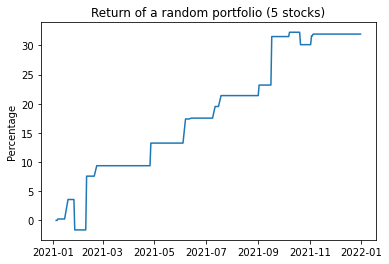

In [96]:
portfolio.plot_portfolio()